In [23]:
## Практикум 2. 
### Класифiкацiя зображень моделями багатошарових перcептронiв у TensorFlow
#### Варіант 28 (natural_images)

In [24]:
# model_1 : 1 softmax + SGD
#model_2 : 5 gloro tanh + SGD
#model_3 : 5 hi relu + SGD
#model_4 : 5 hi lrelu + SGD
#model_5 : 5 hi Prelu + SGD
#model_6 : 5 hi ELU + SGD
#model_7 : 5 hi ELU + Nesterov
#model_8 : 5 hi ELU + Adagrad
#model_9 : 5 hi ELU + Adadelte
#model_10 : 5 hi ELU + Adam
#model_11 : 5 hi ELU + Adagrad + BN + Dropout
#model_12 : 5 hi ELU + Adagrad + BN + Dropout + l1 + l2 + max
#model_13 : 5 hi ELU + Adagrad + BN + Dropout

In [1]:
import warnings
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os 
import datetime
import random
import tensorflow as tf
from shutil import copyfile
from keras.utils import to_categorical
from keras import backend as K
from keras import initializers, optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import LeakyReLU, PReLU, ELU, BatchNormalization, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.utils import shuffle
import tensorflow_addons as tfa 
from keras.backend import clear_session
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext tensorboard
plt.rcParams["figure.figsize"] = (16,20)

In [2]:
!del /q %TMP%\.tensorboard-info\*

In [3]:
%tensorboard --logdir logs --host localhost

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7468.

In [4]:
folder = 'natural_images2/'
names = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
photos, labels = list(), list()
for file in tqdm (os.listdir(folder)):
    for i in range(len(names)):
        if file.startswith(names[i]):
            output = i
            break
    try:
        photo = load_img(folder + file, target_size=(200, 200))
        photo = img_to_array(photo)
        photos.append(photo)
        labels.append(output)
    except:
        pass

photos, labels = shuffle(photos, labels, random_state=42)
train_x, train_y = np.asarray(photos[:5520])/255, np.asarray(labels[:5520], dtype=float)
test_x, test_y = np.asarray(photos[5520:])/255, np.asarray(labels[5520:],dtype=float) 


100%|█████████████████████████████████████████████████████████████████████████████| 6899/6899 [00:42<00:00, 164.03it/s]


In [7]:
np.save('train_x.npy', train_x)
np.save('train_y.npy', train_y)
np.save('test_x.npy', test_x)
np.save('test_y.npy', test_y)


In [5]:
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(5520, 200, 200, 3) (5520,) (1379, 200, 200, 3) (1379,)


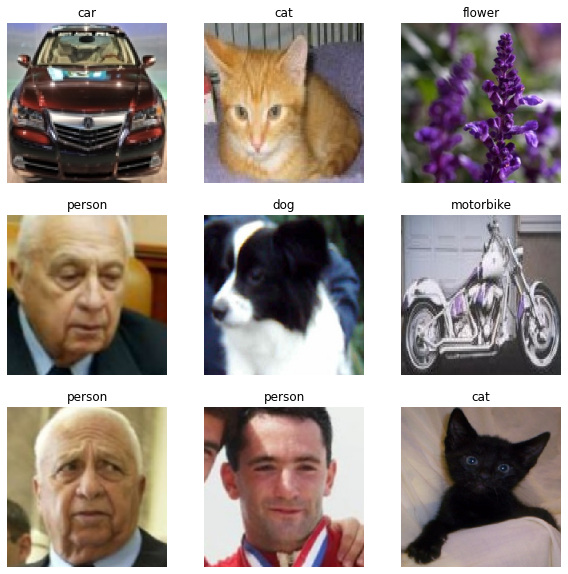

In [5]:
plt.figure(figsize=(10, 10))
for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(train_x[i])
        plt.title(names[int(train_y[i])])
        plt.axis("off")


In [11]:
test_y = to_categorical(test_y)
train_y = to_categorical(train_y)

In [12]:
f1 = tfa.metrics.F1Score(8, 'macro')

In [8]:
log_dir = "logs/model_1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
#4) Побудувати i навчити базову модель з єдиним вихiдним шаром softmax.
#Для створення шару можна використати функцiю tf.layers.dense. 
#Ваги iнiцiалiзувати невеликими випадковими значеннями, якi нормально
#розподiленi з нульовим середнiм та одиничною дисперсiєю.

In [10]:
model = Sequential()
initializer = initializers.RandomNormal(mean=0.0, stddev=1)
opt = optimizers.SGD(learning_rate=0.001)
model.add(Flatten())
model.add(Dense(8, kernel_initializer=initializer, activation=tf.nn.softmax))
model.compile(loss='categorical_crossentropy', metrics = ["accuracy", f1, "AUC"])
history = model.fit(x=train_x, y=train_y, validation_data=(test_x, test_y),steps_per_epoch=len(train_x),
                    validation_steps=len(test_x), epochs=30, verbose=1,callbacks=[tensorboard_callback])

Epoch 1/30
5520/5520 [==============================] - 67s 12ms/step - loss: 87.0818 - accuracy: 0.4015 - f1_score: 0.3866 - auc: 0.6627 - val_loss: 65.8689 - val_accuracy: 0.5033 - val_f1_score: 0.4816 - val_auc: 0.7201
Epoch 2/30
5520/5520 [==============================] - 63s 11ms/step - loss: 49.6895 - accuracy: 0.6047 - f1_score: 0.5836 - auc: 0.7794 - val_loss: 47.3662 - val_accuracy: 0.6642 - val_f1_score: 0.6136 - val_auc: 0.8142
Epoch 3/30
5520/5520 [==============================] - 64s 12ms/step - loss: 42.2486 - accuracy: 0.6420 - f1_score: 0.6277 - auc: 0.8008 - val_loss: 38.8603 - val_accuracy: 0.6461 - val_f1_score: 0.6310 - val_auc: 0.8046
Epoch 4/30
5520/5520 [==============================] - 65s 12ms/step - loss: 40.7840 - accuracy: 0.6546 - f1_score: 0.6450 - auc: 0.8083 - val_loss: 67.0243 - val_accuracy: 0.6041 - val_f1_score: 0.5536 - val_auc: 0.7777
Epoch 5/30
5520/5520 [==============================] - 62s 11ms/step - loss: 36.6309 - accuracy: 0.6896 - f1_sc

In [11]:
#6)Моделi iз симетричними функцiями активацiї tanh навчити методом ґрадiєнтного спуску, використовуючи iнiцiалiзацiю ваг Глоро.

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
BATCH_SIZE = 64

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [13]:
log_dir = "logs/model_2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
model_2 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD()
model_2.add(Flatten())
model_2.add(Dense(1084, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(408, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(250, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(100, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(60, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(8, kernel_initializer=initializer,activation=tf.nn.softmax))
model_2.compile(loss = 'categorical_crossentropy', metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_2 = model_2.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                       callbacks=[tensorboard_callback])


Epoch 1/30
87/87 [==============================] - 43s 460ms/step - loss: 1.9351 - accuracy: 0.3139 - f1_score: 0.4451 - auc: 0.6928 - val_loss: 1.4347 - val_accuracy: 0.4808 - val_f1_score: 0.3826 - val_auc: 0.8421
Epoch 2/30
87/87 [==============================] - 40s 455ms/step - loss: 1.2558 - accuracy: 0.5726 - f1_score: 0.5410 - auc: 0.8875 - val_loss: 1.0620 - val_accuracy: 0.6273 - val_f1_score: 0.5883 - val_auc: 0.9211
Epoch 3/30
87/87 [==============================] - 38s 441ms/step - loss: 0.9890 - accuracy: 0.6656 - f1_score: 0.6419 - auc: 0.9340 - val_loss: 0.9508 - val_accuracy: 0.6621 - val_f1_score: 0.6374 - val_auc: 0.9384
Epoch 4/30
87/87 [==============================] - 38s 440ms/step - loss: 0.8221 - accuracy: 0.7215 - f1_score: 0.7011 - auc: 0.9555 - val_loss: 0.9015 - val_accuracy: 0.6708 - val_f1_score: 0.6490 - val_auc: 0.9436
Epoch 5/30
87/87 [==============================] - 39s 443ms/step - loss: 0.7263 - accuracy: 0.7524 - f1_score: 0.7366 - auc: 0.965

In [15]:
log_dir = "logs/model_3.2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_callbacks = [TensorBoard(log_dir=log_dir, histogram_freq=1),
                ModelCheckpoint(filepath='save/checkpoint/model_3/model.{epoch:02d}-{accuracy:.2f}',
                monitor='accuracy',
                mode='max',
                save_best_only=True)
               ]

In [16]:
model_3 = Sequential()
initializer = initializers.HeNormal()
opt = optimizers.SGD()
model_3.add(Flatten())
model_3.add(Dense(1084, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(408, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(250, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(100, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(60, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(8, kernel_initializer=initializers.GlorotUniform(),activation=tf.nn.softmax))
model_3.compile(loss = 'categorical_crossentropy', metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_3 = model_3.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                       callbacks = my_callbacks)

Epoch 1/30
87/87 [==============================] - 46s 481ms/step - loss: 3.4199 - accuracy: 0.2179 - f1_score: 0.4423 - auc: 0.5985 - val_loss: 1.6851 - val_accuracy: 0.3684 - val_f1_score: 0.2670 - val_auc: 0.7771
INFO:tensorflow:Assets written to: save/checkpoint/model_3\model.01-0.31\assets
Epoch 2/30
87/87 [==============================] - 45s 511ms/step - loss: 1.4711 - accuracy: 0.4701 - f1_score: 0.4283 - auc: 0.8315 - val_loss: 1.3060 - val_accuracy: 0.5134 - val_f1_score: 0.4695 - val_auc: 0.8754
INFO:tensorflow:Assets written to: save/checkpoint/model_3\model.02-0.52\assets
Epoch 3/30
87/87 [==============================] - 42s 484ms/step - loss: 1.1648 - accuracy: 0.5822 - f1_score: 0.5490 - auc: 0.8991 - val_loss: 0.9716 - val_accuracy: 0.6577 - val_f1_score: 0.6365 - val_auc: 0.9317
INFO:tensorflow:Assets written to: save/checkpoint/model_3\model.03-0.61\assets
Epoch 4/30
87/87 [==============================] - 48s 545ms/step - loss: 1.1069 - accuracy: 0.6158 - f1_sco

INFO:tensorflow:Assets written to: save/checkpoint/model_3\model.30-0.94\assets


In [41]:
model_3_load = load_model('save/checkpoint/model_3/model.30-0.94/', compile=False)

In [18]:
log_dir = "logs/model_4/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
model_4 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD()
model_4.add(Flatten())
model_4.add(Dense(1084, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(408, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(250, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(100, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(60, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(8, kernel_initializer=initializers.GlorotUniform(),activation=tf.nn.softmax))
model_4.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_4 = model_4.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
87/87 [==============================] - 45s 472ms/step - loss: 2.1923 - accuracy: 0.2792 - f1_score: 0.4652 - auc: 0.6615 - val_loss: 1.2586 - val_accuracy: 0.5475 - val_f1_score: 0.4783 - val_auc: 0.8817
Epoch 2/30
87/87 [==============================] - 40s 453ms/step - loss: 1.2598 - accuracy: 0.5455 - f1_score: 0.5139 - auc: 0.8804 - val_loss: 1.0804 - val_accuracy: 0.5983 - val_f1_score: 0.5561 - val_auc: 0.9125
Epoch 3/30
87/87 [==============================] - 39s 445ms/step - loss: 1.0110 - accuracy: 0.6305 - f1_score: 0.6017 - auc: 0.9250 - val_loss: 0.9163 - val_accuracy: 0.6570 - val_f1_score: 0.6438 - val_auc: 0.9399
Epoch 4/30
87/87 [==============================] - 39s 442ms/step - loss: 0.8399 - accuracy: 0.6841 - f1_score: 0.6601 - auc: 0.9496 - val_loss: 0.9744 - val_accuracy: 0.6468 - val_f1_score: 0.6271 - val_auc: 0.9308
Epoch 5/30
87/87 [==============================] - 41s 467ms/step - loss: 0.7753 - accuracy: 0.7156 - f1_score: 0.6945 - auc: 0.956

In [9]:
log_dir = "logs/model_5/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [10]:
model_5 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD()
model_5.add(Flatten())
model_5.add(Dense(1084, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(408, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(250, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(100, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(60, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(8, kernel_initializer=initializers.GlorotUniform(),activation=tf.nn.softmax))
model_5.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_5 = model_5.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
87/87 [==============================] - 71s 491ms/step - loss: 1.9452 - accuracy: 0.2627 - f1_score: 0.2195 - auc: 0.6520 - val_loss: 1.4429 - val_accuracy: 0.4467 - val_f1_score: 0.3732 - val_auc: 0.8382
Epoch 2/30
87/87 [==============================] - 42s 477ms/step - loss: 1.3622 - accuracy: 0.5038 - f1_score: 0.4610 - auc: 0.8591 - val_loss: 1.1445 - val_accuracy: 0.5787 - val_f1_score: 0.5433 - val_auc: 0.9040
Epoch 3/30
87/87 [==============================] - 39s 453ms/step - loss: 1.1024 - accuracy: 0.6000 - f1_score: 0.5728 - auc: 0.9102 - val_loss: 1.1590 - val_accuracy: 0.5794 - val_f1_score: 0.5243 - val_auc: 0.8993
Epoch 4/30
87/87 [==============================] - 41s 471ms/step - loss: 0.9091 - accuracy: 0.6717 - f1_score: 0.6480 - auc: 0.9399 - val_loss: 1.0456 - val_accuracy: 0.6048 - val_f1_score: 0.5684 - val_auc: 0.9192
Epoch 5/30
87/87 [==============================] - 45s 518ms/step - loss: 0.7861 - accuracy: 0.7160 - f1_score: 0.6945 - auc: 0.955

In [8]:
log_dir = "logs/model_6/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
model_6 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD()
model_6.add(Flatten())
model_6.add(Dense(1084, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(408, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(250, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(100, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(60, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(8, kernel_initializer=initializers.GlorotUniform(),activation=tf.nn.softmax))
model_6.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_6 = model_6.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
87/87 [==============================] - 58s 503ms/step - loss: 3.4719 - accuracy: 0.2417 - f1_score: 0.4352 - auc: 0.6110 - val_loss: 1.1962 - val_accuracy: 0.5685 - val_f1_score: 0.5104 - val_auc: 0.8990
Epoch 2/30
87/87 [==============================] - 48s 526ms/step - loss: 1.2651 - accuracy: 0.5380 - f1_score: 0.5071 - auc: 0.8803 - val_loss: 0.9265 - val_accuracy: 0.6476 - val_f1_score: 0.6105 - val_auc: 0.9395
Epoch 3/30
87/87 [==============================] - 72s 826ms/step - loss: 0.9637 - accuracy: 0.6508 - f1_score: 0.6277 - auc: 0.9323 - val_loss: 1.0037 - val_accuracy: 0.6244 - val_f1_score: 0.6127 - val_auc: 0.9273
Epoch 4/30
87/87 [==============================] - 50s 557ms/step - loss: 0.7966 - accuracy: 0.7076 - f1_score: 0.6883 - auc: 0.9546 - val_loss: 0.8449 - val_accuracy: 0.6831 - val_f1_score: 0.6696 - val_auc: 0.9479
Epoch 5/30
87/87 [==============================] - 44s 505ms/step - loss: 0.6670 - accuracy: 0.7528 - f1_score: 0.7360 - auc: 0.968

In [11]:
log_dir = "logs/model_7_Nest/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
model_7 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD(nesterov=True,momentum=0.7)
model_7.add(Flatten())
model_7.add(Dense(1084, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(408, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(250, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(100, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(60, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(8, kernel_initializer=initializer,activation=tf.nn.softmax))
model_7.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_7 = model_7.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
87/87 [==============================] - 89s 784ms/step - loss: 5.0208 - accuracy: 0.2208 - f1_score: 0.1868 - auc: 0.5937 - val_loss: 1.8422 - val_accuracy: 0.3742 - val_f1_score: 0.2499 - val_auc: 0.7930
Epoch 2/30
87/87 [==============================] - 64s 731ms/step - loss: 1.3258 - accuracy: 0.5156 - f1_score: 0.4786 - auc: 0.8655 - val_loss: 0.9437 - val_accuracy: 0.6642 - val_f1_score: 0.6207 - val_auc: 0.9375
Epoch 3/30
87/87 [==============================] - 61s 696ms/step - loss: 0.8724 - accuracy: 0.6799 - f1_score: 0.6566 - auc: 0.9450 - val_loss: 1.4890 - val_accuracy: 0.5243 - val_f1_score: 0.4621 - val_auc: 0.8516
Epoch 4/30
87/87 [==============================] - 60s 682ms/step - loss: 0.8206 - accuracy: 0.6922 - f1_score: 0.6701 - auc: 0.9495 - val_loss: 0.8484 - val_accuracy: 0.6889 - val_f1_score: 0.6587 - val_auc: 0.9475
Epoch 5/30
87/87 [==============================] - 59s 673ms/step - loss: 0.6480 - accuracy: 0.7523 - f1_score: 0.7315 - auc: 0.969

In [39]:
log_dir = "logs/model_8_Adagrad/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [40]:
model_8 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adagrad()
model_8.add(Flatten())
model_8.add(Dense(1084, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(408, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(250, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(100, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(60, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(8, kernel_initializer=initializers.GlorotUniform(),activation=tf.nn.softmax))
model_8.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_8 = model_8.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
87/87 [==============================] - 84s 878ms/step - loss: 2.0040 - accuracy: 0.3473 - f1_score: 0.3146 - auc: 0.7101 - val_loss: 1.1714 - val_accuracy: 0.5577 - val_f1_score: 0.4878 - val_auc: 0.8970
Epoch 2/30
87/87 [==============================] - 70s 801ms/step - loss: 1.0647 - accuracy: 0.6154 - f1_score: 0.5843 - auc: 0.9187 - val_loss: 0.9523 - val_accuracy: 0.6534 - val_f1_score: 0.6106 - val_auc: 0.9344
Epoch 3/30
87/87 [==============================] - 70s 799ms/step - loss: 0.8651 - accuracy: 0.6924 - f1_score: 0.6701 - auc: 0.9481 - val_loss: 0.8537 - val_accuracy: 0.6751 - val_f1_score: 0.6467 - val_auc: 0.9480
Epoch 4/30
87/87 [==============================] - 69s 786ms/step - loss: 0.7439 - accuracy: 0.7367 - f1_score: 0.7157 - auc: 0.9622 - val_loss: 0.7866 - val_accuracy: 0.6998 - val_f1_score: 0.6789 - val_auc: 0.9559
Epoch 5/30
87/87 [==============================] - 61s 703ms/step - loss: 0.6654 - accuracy: 0.7594 - f1_score: 0.7403 - auc: 0.969

In [16]:
log_dir = "logs/model_9_Adadel/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
model_9 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adadelta()
model_9.add(Flatten())
model_9.add(Dense(1084, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(408, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(250, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(100, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(60, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(8, kernel_initializer=initializers.GlorotUniform(),activation=tf.nn.softmax))
model_9.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_9 = model_9.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
87/87 [==============================] - 82s 870ms/step - loss: 1.7029 - accuracy: 0.3980 - f1_score: 0.5594 - auc: 0.7494 - val_loss: 1.2372 - val_accuracy: 0.5373 - val_f1_score: 0.4639 - val_auc: 0.8841
Epoch 2/30
87/87 [==============================] - 72s 828ms/step - loss: 1.1037 - accuracy: 0.6351 - f1_score: 0.6070 - auc: 0.9144 - val_loss: 0.9910 - val_accuracy: 0.6526 - val_f1_score: 0.6238 - val_auc: 0.9305
Epoch 3/30
87/87 [==============================] - 73s 841ms/step - loss: 0.9238 - accuracy: 0.6917 - f1_score: 0.6720 - auc: 0.9424 - val_loss: 0.8996 - val_accuracy: 0.6802 - val_f1_score: 0.6614 - val_auc: 0.9431
Epoch 4/30
87/87 [==============================] - 72s 831ms/step - loss: 0.8208 - accuracy: 0.7197 - f1_score: 0.7009 - auc: 0.9555 - val_loss: 0.8539 - val_accuracy: 0.6991 - val_f1_score: 0.6843 - val_auc: 0.9485
Epoch 5/30
87/87 [==============================] - 77s 881ms/step - loss: 0.7517 - accuracy: 0.7418 - f1_score: 0.7251 - auc: 0.963

In [10]:
log_dir = "logs/model_10_Adam/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
model_10 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adam()
model_10.add(Flatten())
model_10.add(Dense(1084, kernel_initializer=initializer))
model_10.add(ELU())
model_10.add(Dense(408, kernel_initializer=initializer))
model_10.add(ELU())
model_10.add(Dense(250, kernel_initializer=initializer))
model_10.add(ELU())
model_10.add(Dense(100, kernel_initializer=initializer))
model_10.add(ELU())
model_10.add(Dense(60, kernel_initializer=initializer))
model_10.add(ELU())
model_101.add(Dense(8, kernel_initializer=initializers.GlorotUniform(),activation=tf.nn.softmax))
model_10.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_10 = model_10.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
87/87 [==============================] - 86s 900ms/step - loss: 34.8668 - accuracy: 0.2101 - f1_score: 0.1928 - auc: 0.5595 - val_loss: 1.6444 - val_accuracy: 0.5417 - val_f1_score: 0.4472 - val_auc: 0.8338
Epoch 2/30
87/87 [==============================] - 77s 882ms/step - loss: 1.3181 - accuracy: 0.5615 - f1_score: 0.5300 - auc: 0.8784 - val_loss: 1.1129 - val_accuracy: 0.6367 - val_f1_score: 0.5879 - val_auc: 0.9118
Epoch 3/30
87/87 [==============================] - 74s 851ms/step - loss: 0.9905 - accuracy: 0.6628 - f1_score: 0.6424 - auc: 0.9276 - val_loss: 0.9713 - val_accuracy: 0.6817 - val_f1_score: 0.6401 - val_auc: 0.9324
Epoch 4/30
87/87 [==============================] - 73s 838ms/step - loss: 0.8400 - accuracy: 0.7089 - f1_score: 0.6918 - auc: 0.9478 - val_loss: 0.8900 - val_accuracy: 0.7056 - val_f1_score: 0.6640 - val_auc: 0.9426
Epoch 5/30
87/87 [==============================] - 82s 936ms/step - loss: 0.7630 - accuracy: 0.7353 - f1_score: 0.7190 - auc: 0.95

In [18]:
log_dir = "logs/model_11_Adagrad_bnorm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
model_11 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adagrad()
model_11.add(Flatten())
model_11.add(BatchNormalization())
model_11.add(Dense(1084, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(408, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(250, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(100, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(60, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(8, kernel_initializer=initializers.GlorotUniform(),activation=tf.nn.softmax))
model_11.add(BatchNormalization())
model_11.add(Activation(tf.nn.softmax))
model_11.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_11 = model_11.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1, callbacks=[tensorboard_callback] )

Epoch 1/30
87/87 [==============================] - 118s 1s/step - loss: 1.2421 - accuracy: 0.6157 - f1_score: 0.6784 - auc: 0.8748 - val_loss: 1.6779 - val_accuracy: 0.6099 - val_f1_score: 0.5911 - val_auc: 0.8977
Epoch 2/30
87/87 [==============================] - 88s 1s/step - loss: 0.6735 - accuracy: 0.8504 - f1_score: 0.8423 - auc: 0.9801 - val_loss: 1.3361 - val_accuracy: 0.7730 - val_f1_score: 0.7494 - val_auc: 0.9681
Epoch 3/30
87/87 [==============================] - 87s 997ms/step - loss: 0.5304 - accuracy: 0.9230 - f1_score: 0.9186 - auc: 0.9932 - val_loss: 1.0973 - val_accuracy: 0.7991 - val_f1_score: 0.7835 - val_auc: 0.9740
Epoch 4/30
87/87 [==============================] - 87s 1s/step - loss: 0.4525 - accuracy: 0.9561 - f1_score: 0.9536 - auc: 0.9975 - val_loss: 0.9177 - val_accuracy: 0.8006 - val_f1_score: 0.7832 - val_auc: 0.9744
Epoch 5/30
87/87 [==============================] - 86s 985ms/step - loss: 0.4036 - accuracy: 0.9808 - f1_score: 0.9798 - auc: 0.9988 - val_

In [14]:
log_dir = "logs/model_121_Adagrad_bnorm_dropout/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
model_121 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adagrad(learning_rate=0.1)
model_121.add(Flatten())
model_121.add(BatchNormalization())
model_121.add(Dropout(0.8))
model_121.add(Dense(1084, kernel_initializer=initializer))
model_121.add(BatchNormalization())
model_121.add(ELU())
model_121.add(Dropout(0.5))
model_121.add(Dense(408, kernel_initializer=initializer))
model_121.add(BatchNormalization())
model_121.add(ELU())
model_121.add(Dropout(0.5))
model_121.add(Dense(250, kernel_initializer=initializer))
model_121.add(BatchNormalization())
model_121.add(ELU())
model_121.add(Dropout(0.5))
model_121.add(Dense(100, kernel_initializer=initializer))
model_121.add(BatchNormalization())
model_121.add(ELU())
model_121.add(Dropout(0.2))
model_121.add(Dense(60, kernel_initializer=initializer))
model_121.add(BatchNormalization())
model_121.add(ELU())
model_121.add(Dense(8, kernel_initializer=initializers.GlorotUniform()))
model_121.add(BatchNormalization())
model_121.add(Activation(tf.nn.softmax))
model_121.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_121 = model_121.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
87/87 [==============================] - 123s 1s/step - loss: 1.4127 - accuracy: 0.5070 - f1_score: 0.4819 - auc: 0.8455 - val_loss: 1.5078 - val_accuracy: 0.5236 - val_f1_score: 0.4684 - val_auc: 0.8740
Epoch 2/30
87/87 [==============================] - 110s 1s/step - loss: 0.8902 - accuracy: 0.6963 - f1_score: 0.6605 - auc: 0.9466 - val_loss: 0.7756 - val_accuracy: 0.7194 - val_f1_score: 0.6849 - val_auc: 0.9564
Epoch 3/30
87/87 [==============================] - 101s 1s/step - loss: 0.7665 - accuracy: 0.7336 - f1_score: 0.7045 - auc: 0.9594 - val_loss: 0.6858 - val_accuracy: 0.7368 - val_f1_score: 0.7034 - val_auc: 0.9665
Epoch 4/30
87/87 [==============================] - 119s 1s/step - loss: 0.6908 - accuracy: 0.7601 - f1_score: 0.7349 - auc: 0.9665 - val_loss: 0.5908 - val_accuracy: 0.7810 - val_f1_score: 0.7435 - val_auc: 0.9742
Epoch 5/30
87/87 [==============================] - 107s 1s/step - loss: 0.6257 - accuracy: 0.7688 - f1_score: 0.7425 - auc: 0.9735 - val_lo

In [27]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=4, mode="max")

In [28]:
history_121 = model_121.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset, validation_steps=len(test_dataset), epochs=15, verbose=1,
                      callbacks=[early_stop] )

Epoch 1/15
87/87 [==============================] - 94s 1s/step - loss: 0.2039 - accuracy: 0.9286 - f1_score: 0.9226 - auc: 0.9970 - val_loss: 0.5598 - val_accuracy: 0.8245 - val_f1_score: 0.8158 - val_auc: 0.9759
Epoch 2/15
87/87 [==============================] - 95s 1s/step - loss: 0.2113 - accuracy: 0.9245 - f1_score: 0.9191 - auc: 0.9967 - val_loss: 0.5316 - val_accuracy: 0.8310 - val_f1_score: 0.8206 - val_auc: 0.9788
Epoch 3/15
87/87 [==============================] - 97s 1s/step - loss: 0.2027 - accuracy: 0.9299 - f1_score: 0.9242 - auc: 0.9968 - val_loss: 0.5525 - val_accuracy: 0.8281 - val_f1_score: 0.8195 - val_auc: 0.9769
Epoch 4/15
87/87 [==============================] - 97s 1s/step - loss: 0.1905 - accuracy: 0.9342 - f1_score: 0.9292 - auc: 0.9971 - val_loss: 0.5351 - val_accuracy: 0.8325 - val_f1_score: 0.8235 - val_auc: 0.9792
Epoch 5/15
87/87 [==============================] - 102s 1s/step - loss: 0.1898 - accuracy: 0.9380 - f1_score: 0.9336 - auc: 0.9971 - val_loss: 

In [44]:
train = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test = tf.data.Dataset.from_tensor_slices((test_x, test_y))
BATCH_SIZE = 128

train = train_dataset.batch(BATCH_SIZE)
test = test_dataset.batch(BATCH_SIZE)

In [53]:
log_dir = "logs/model_13_Adagrad_bnorm_dropout_reg/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [42]:
model_13 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adagrad(learning_rate=0.1)
model_13.add(Flatten())
model_13.add(BatchNormalization())
model_13.add(Dropout(0.8))
model_13.add(Dense(1084, kernel_initializer=initializer, 
                  kernel_regularizer=regularizers.l2(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dropout(0.5))
model_13.add(Dense(408, kernel_initializer=initializer,
                   kernel_regularizer=regularizers.l2(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dropout(0.5))
model_13.add(Dense(256, kernel_initializer=initializer,
                   kernel_regularizer=regularizers.l2(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dropout(0.5))
model_13.add(Dense(120, kernel_initializer=initializer,
                   kernel_regularizer=regularizers.l1(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dropout(0.2))
model_13.add(Dense(64, kernel_initializer=initializer,
                   kernel_regularizer=regularizers.l1(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dense(8, kernel_initializer=initializers.GlorotUniform(),
                   kernel_regularizer=regularizers.l1(1e-6),
                  kernel_constraint=max_norm(1)
                  ))
model_13.add(BatchNormalization())
model_13.add(Activation(tf.nn.softmax))
model_13.compile(loss = "categorical_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_13 = model_13.fit(train_dataset, steps_per_epoch=len(train_dataset), validation_data=test_dataset, validation_steps=len(test_dataset),
                          epochs=10, verbose=1, callbacks=[tensorboard_callback] )

Epoch 1/10
87/87 [==============================] - 299s 3s/step - loss: 1.4012 - accuracy: 0.5068 - f1_score: 0.6320 - auc: 0.8471 - val_loss: 1.4759 - val_accuracy: 0.5337 - val_f1_score: 0.4594 - val_auc: 0.8684
Epoch 2/10
87/87 [==============================] - 275s 3s/step - loss: 0.8701 - accuracy: 0.7009 - f1_score: 0.6625 - auc: 0.9492 - val_loss: 0.7455 - val_accuracy: 0.7360 - val_f1_score: 0.7086 - val_auc: 0.9597
Epoch 3/10
87/87 [==============================] - 276s 3s/step - loss: 0.7404 - accuracy: 0.7446 - f1_score: 0.7137 - auc: 0.9629 - val_loss: 0.6489 - val_accuracy: 0.7643 - val_f1_score: 0.7432 - val_auc: 0.9697
Epoch 4/10
87/87 [==============================] - 276s 3s/step - loss: 0.6869 - accuracy: 0.7543 - f1_score: 0.7313 - auc: 0.9671 - val_loss: 0.5913 - val_accuracy: 0.7904 - val_f1_score: 0.7695 - val_auc: 0.9748
Epoch 5/10
87/87 [==============================] - ETA: 0s - loss: 0.6266 - accuracy: 0.7748 - f1_score: 0.7534 - auc: 0.9732

Exception ignored in: <function ScopedTFGraph.__del__ at 0x000001BBEEFE6378>
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter


87/87 [==============================] - 298s 3s/step - loss: 0.6264 - accuracy: 0.7749 - f1_score: 0.7535 - auc: 0.9732 - val_loss: 0.6753 - val_accuracy: 0.7440 - val_f1_score: 0.7127 - val_auc: 0.9664
Epoch 6/10
87/87 [==============================] - 303s 3s/step - loss: 0.5782 - accuracy: 0.7879 - f1_score: 0.7663 - auc: 0.9773 - val_loss: 0.6054 - val_accuracy: 0.7803 - val_f1_score: 0.7606 - val_auc: 0.9728
Epoch 7/10
87/87 [==============================] - 285s 3s/step - loss: 0.5527 - accuracy: 0.8010 - f1_score: 0.7831 - auc: 0.9787 - val_loss: 0.5387 - val_accuracy: 0.8020 - val_f1_score: 0.7858 - val_auc: 0.9784
Epoch 8/10
87/87 [==============================] - 280s 3s/step - loss: 0.5285 - accuracy: 0.8067 - f1_score: 0.7890 - auc: 0.9801 - val_loss: 0.6055 - val_accuracy: 0.7810 - val_f1_score: 0.7665 - val_auc: 0.9731
Epoch 9/10
87/87 [==============================] - 278s 3s/step - loss: 0.5056 - accuracy: 0.8155 - f1_score: 0.7991 - auc: 0.9822 - val_loss: 0.5980 

In [54]:
model_13.fit(train_dataset, steps_per_epoch=len(train_dataset), validation_data=test_dataset, validation_steps=len(test_dataset),
                          epochs=10, verbose=1, callbacks=[tensorboard_callback] )

Epoch 1/10
87/87 [==============================] - 294s 3s/step - loss: 0.4038 - accuracy: 0.8531 - f1_score: 0.8395 - auc: 0.9889 - val_loss: 0.5649 - val_accuracy: 0.8093 - val_f1_score: 0.7988 - val_auc: 0.9751
Epoch 2/10
87/87 [==============================] - 279s 3s/step - loss: 0.3942 - accuracy: 0.8529 - f1_score: 0.8396 - auc: 0.9892 - val_loss: 0.6347 - val_accuracy: 0.7766 - val_f1_score: 0.7593 - val_auc: 0.9688
Epoch 3/10
87/87 [==============================] - 280s 3s/step - loss: 0.3808 - accuracy: 0.8685 - f1_score: 0.8582 - auc: 0.9896 - val_loss: 0.6976 - val_accuracy: 0.7672 - val_f1_score: 0.7481 - val_auc: 0.9661
Epoch 4/10
87/87 [==============================] - 279s 3s/step - loss: 0.3705 - accuracy: 0.8665 - f1_score: 0.8547 - auc: 0.9903 - val_loss: 0.5476 - val_accuracy: 0.8122 - val_f1_score: 0.7986 - val_auc: 0.9768
Epoch 5/10
87/87 [==============================] - 281s 3s/step - loss: 0.3500 - accuracy: 0.8737 - f1_score: 0.8624 - auc: 0.9916 - val_lo

1/1 [==============================] - 0s 117ms/step


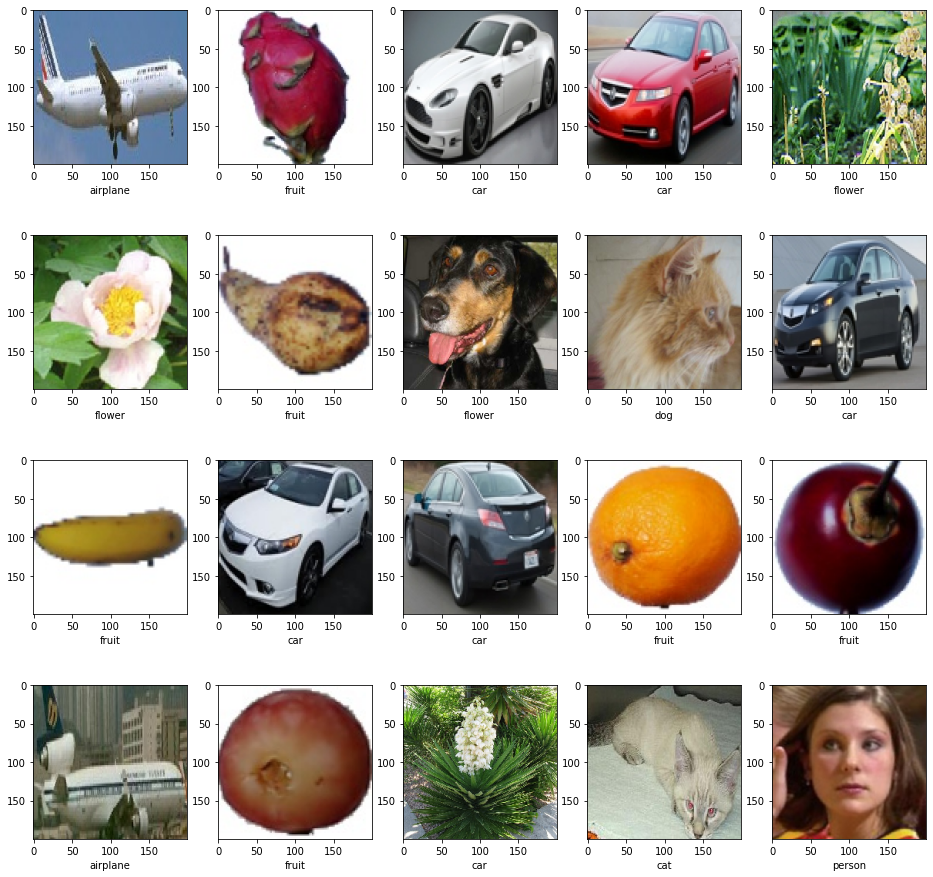

In [24]:
test = test_x[10:30]
predict = model_121.predict_classes(np.array(test), batch_size=21, verbose=1)

    
for i in range(len(test)):
    plt.subplot(5,5,1+i)
    plt.imshow(test[i])
    plt.xlabel(names[predict[i]])

plt.show()